# Auto Tensorization in BitBLAS

Auto detect whether a given operator (gemm, conv2d, stencil, etc.) can be tensorized with given instructions' computation flow (MMA, DP4A, etc.)

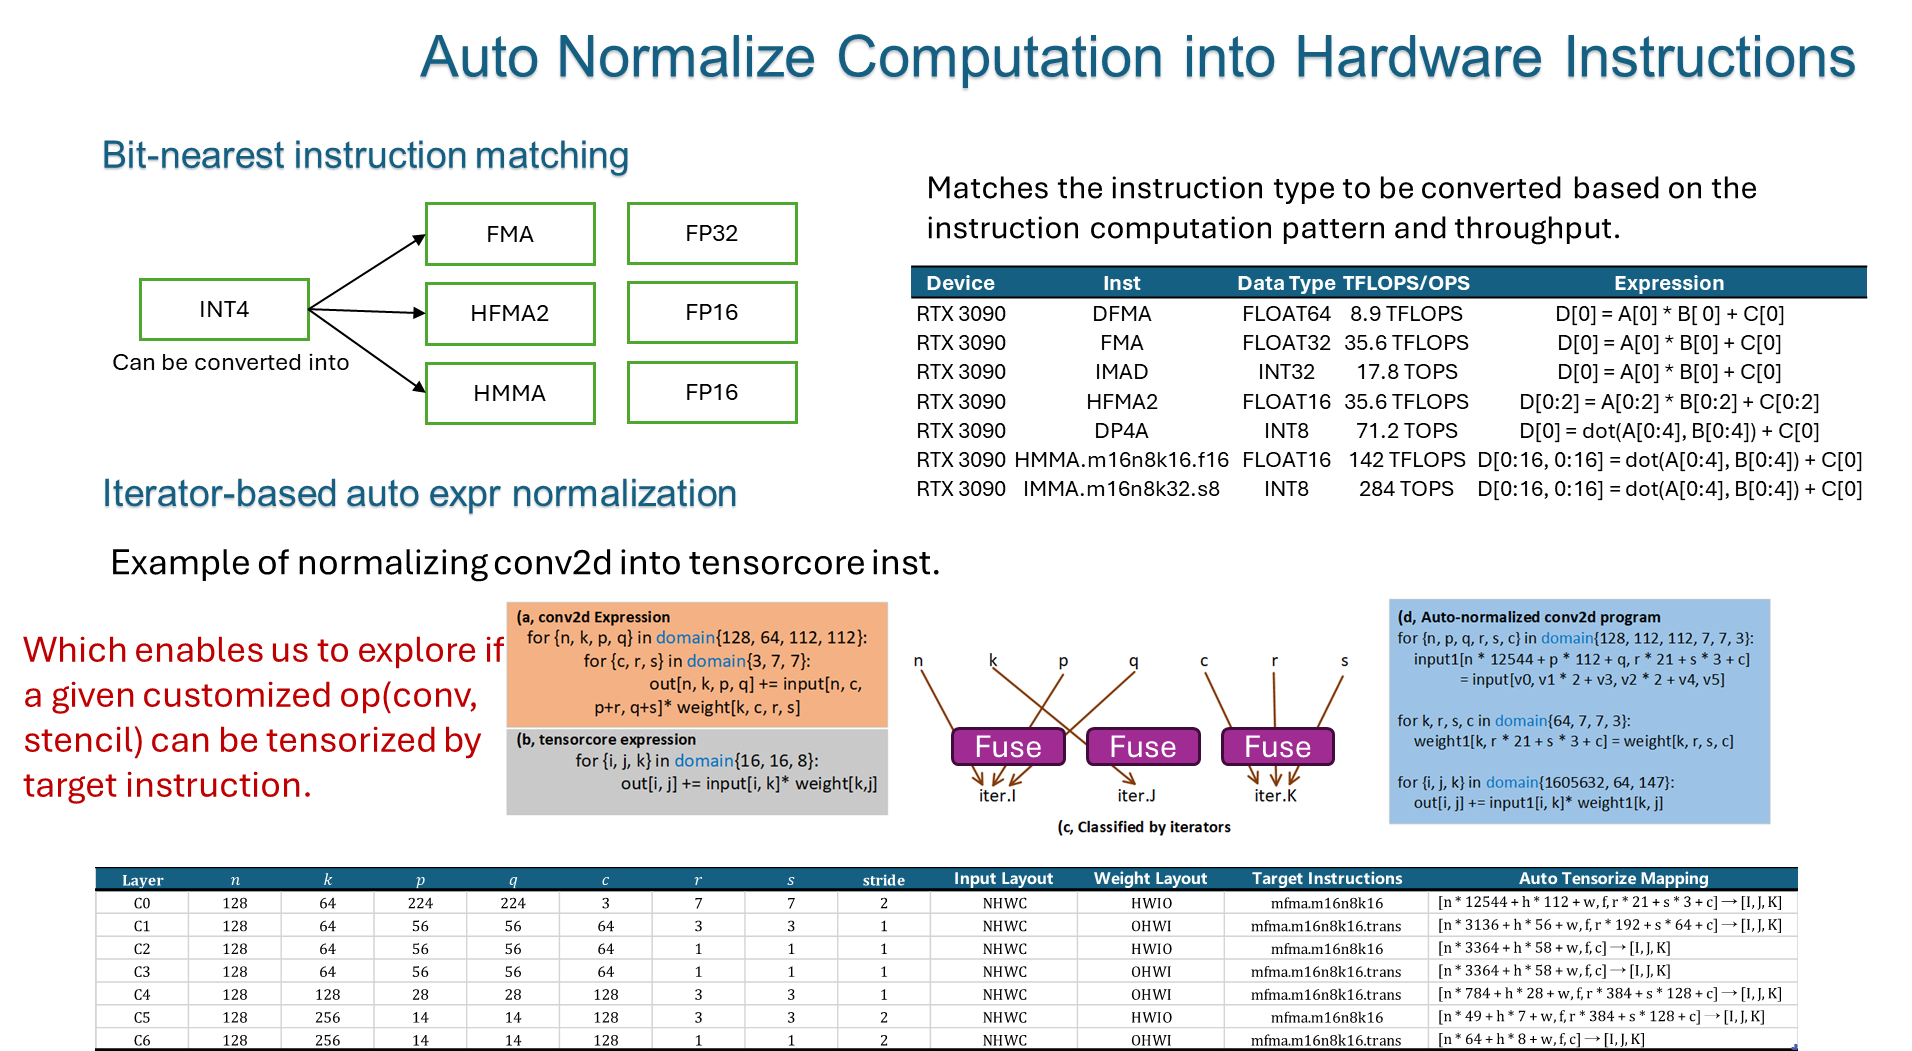

In [2]:
import bitblas
from bitblas import tvm
from tvm import te, tir

Get a convlution expression

In [3]:
def conv2d_nhwc_hwio(n, f, h, w, c, kh, kw, s, d, p, in_dtype="float16", out_dtype="float16"):
    A = te.placeholder((n, h, w, c), name="input", dtype=in_dtype)
    B = te.placeholder((kh, kw, c, f), name="weight", dtype=in_dtype)

    pad_shape = (n, h + 2 * p, w + 2 * p, c)
    pad_value = tir.const(0.0, A.dtype)
    pad = te.compute(
        pad_shape,
        lambda n, h, w, c: te.if_then_else(
            tir.all(
                h >= p,
                w >= p,
                h < pad_shape[1] - p,
                w < pad_shape[2] - p,
            ),
            A[n, h - p, w - p, c],
            pad_value,
        ),
        name="pad",
    )
    kernel_h, kernel_w = kh, kw
    stride_h, stride_w = s, s
    dilation_h, dilation_w = d, d
    out_h = (h + 2 * p - (dilation_h * (kernel_h - 1) + 1)) // stride_h + 1
    out_w = (w + 2 * p - (dilation_w * (kernel_w - 1) + 1)) // stride_w + 1
    out_shape = (n, out_h, out_w, f)
    kh = te.reduce_axis((0, kernel_h), name="kh")
    kw = te.reduce_axis((0, kernel_w), name="kw")
    c = te.reduce_axis((0, c), name="c")
    C = te.compute(
        out_shape,
        lambda n, h, w, f: te.sum(
            pad[
                n,
                h * stride_h + kh * dilation_h,
                w * stride_w + kw * dilation_w,
                c,
            ] * B[kh, kw, c, f],
            axis=[kh, kw, c],
        ),
        name="C",
    )
    return te.create_prim_func([A, B, C])

In [4]:
func = conv2d_nhwc_hwio(128, 64, 224, 224, 64, 1, 1, 2, 1, 3, "float16", "float16")

In [5]:
print(func)

# from tvm.script import tir as T

@T.prim_func
def main(input: T.Buffer((128, 224, 224, 64), "float16"), weight: T.Buffer((1, 1, 64, 64), "float16"), C: T.Buffer((128, 115, 115, 64), "float16")):
    T.func_attr({"tir.noalias": T.bool(True)})
    # with T.block("root"):
    pad = T.alloc_buffer((128, 230, 230, 64), "float16")
    for n, h, w, c in T.grid(128, 230, 230, 64):
        with T.block("pad"):
            v_n, v_h, v_w, v_c = T.axis.remap("SSSS", [n, h, w, c])
            T.reads(input[v_n, v_h - 3, v_w - 3, v_c])
            T.writes(pad[v_n, v_h, v_w, v_c])
            pad[v_n, v_h, v_w, v_c] = T.if_then_else(3 <= v_h and 3 <= v_w and v_h < 227 and v_w < 227, input[v_n, v_h - 3, v_w - 3, v_c], T.float16(0))
    for n, h, w, f, kh, kw, c in T.grid(128, 115, 115, 64, 1, 1, 64):
        with T.block("C"):
            v_n, v_h, v_w, v_f, v_kh, v_kw, v_c = T.axis.remap("SSSSRRR", [n, h, w, f, kh, kw, c])
            T.reads(pad[v_n, v_h * 2 + v_kh, v_w * 2 + v_kw, v_c], weight[v

In [6]:
from bitblas.gpu.matmul_analysis import get_tensorized_func_and_tags
from bitblas.base.arch import CUDA

target = bitblas.auto_detect_nvidia_target()
print(f"{target=}")
arch = CUDA(target)

target='nvidia/geforce-rtx-4090'


## Get Tensorized Function

In [12]:
tensorized_func, tags = get_tensorized_func_and_tags(func, arch.target)
print(tensorized_func)

# from tvm.script import tir as T

@T.prim_func
def main(input: T.Buffer((128, 224, 224, 64), "float16"), weight: T.Buffer((1, 1, 64, 64), "float16"), C: T.Buffer((128, 115, 115, 64), "float16")):
    T.func_attr({"dlight.tensorcore_prenormlized": T.bool(True), "tir.noalias": T.bool(True)})
    # with T.block("root"):
    pad = T.alloc_buffer((128, 230, 230, 64), "float16")
    pad_reindex = T.alloc_buffer((1, 1692800, 64), "float16")
    weight_reindex = T.alloc_buffer((1, 64, 64), "float16")
    C_reindex = T.alloc_buffer((1, 1692800, 64), "float16")
    for n, h, w, c in T.grid(128, 230, 230, 64):
        with T.block("pad"):
            v_n, v_h, v_w, v_c = T.axis.remap("SSSS", [n, h, w, c])
            T.reads(input[v_n, v_h - 3, v_w - 3, v_c])
            T.writes(pad[v_n, v_h, v_w, v_c])
            pad[v_n, v_h, v_w, v_c] = T.if_then_else(3 <= v_h and 3 <= v_w and v_h < 227 and v_w < 227, input[v_n, v_h - 3, v_w - 3, v_c], T.float16(0))
    for ax0, ax1, ax2, ax3, ax4, ax5 in T